<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=300 ALIGN="right">
</figure>

# CEGM1000 Modelling, Uncertainty and Data for Engineers

---

## Exercise Multivariate distributions


## Covariance, correlation and multivariate lognormal distribution

### Objective

Calculate the covariance and correlation coefficient between two random variables and fit and assess a bivariate normal distribution.

### Introduction

In this notebook, we are going to analyze the relationship between wave heights and wave periods from a historical dataset with 42 years of hourly observations. We will follow the next steps:

0. Load libraries and data
1. Calculating the covariance and correlation coefficients
2. Fitting the bivariate normal distribution function
3. Analyzing the conditional bivariate normal distribution function
4. Moving to three dimensions

### 0. Load libraries and data

Install dependences if needed

In [1]:
#!pip install --upgrade pandas numpy scipy statsmodels matplotlib datetime statistics
%matplotlib inline

Import necessary libraries (include more if needed).

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
import datetime
from statistics import mean
from statistics import stdev
import ipywidgets as widgets

Load the database obtained from a buoy from surfdrive.

In [3]:
data = pd.read_csv('SIMAR_node.csv', sep = ',', dtype={'Date (GMT)':'str', 'Hs(m)': 'float', 'Tm(s)': 'float'})
data.head()

,Date (GMT),Hs(m),Tm(s)
0,04/01/1958 00:00,0.47,4.47
1,04/01/1958 01:00,0.45,4.49
2,04/01/1958 02:00,0.43,4.49
3,04/01/1958 03:00,0.42,4.49
4,04/01/1958 04:00,0.40,4.47


Let's format the datetime column and take a look at the time series we have.

*It takes a bit to run!*

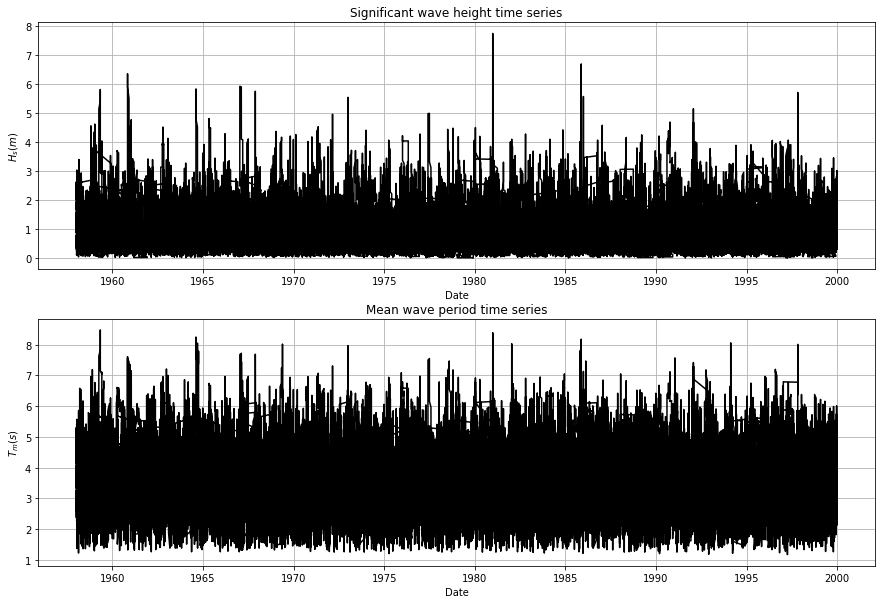

In [4]:
data['Date (GMT)'] = pd.to_datetime(data['Date (GMT)'])

data.set_axis([np.linspace(0, len(data)-1, len(data), dtype=int)], axis = 'index', inplace=True)
fig, axs = plt.subplots(2, 1)
axs[0].plot(data['Date (GMT)'], data['Hs(m)'], 'k', label = '${H_s(m)}$')
axs[0].set_title('Significant wave height time series')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('${H_s (m)}$')
axs[0].grid()
axs[1].plot(data['Date (GMT)'], data['Tm(s)'], 'k', label = '${T_m(s)}$')

axs[1].set_title('Mean wave period time series')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('${T_m (s)}$')
axs[1].grid()
fig.set_size_inches(15, 10)

We may need to further look into the data cleaning, but since there are no clear outlayers or NaN values, we are going ahead with the dataset as it is.

### 1. Calculating the covariance and correlation coefficients

We are interested in the relationship between the two observed variables, namely significant wave height and mean wave period. First, let's see how they look in a scatter plot.

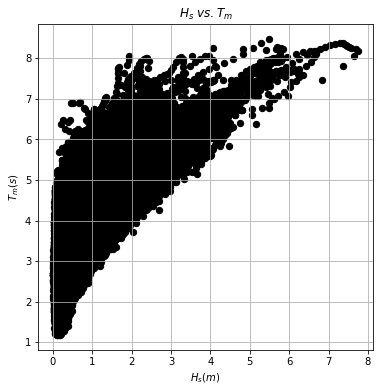

In [5]:
fig, axs = plt.subplots(1, 1)
axs.scatter(data['Hs(m)'], data['Tm(s)'], 40, 'k')
axs.set_title('${H_s \\ vs. T_m}$')
axs.set_ylabel('${T_m (s)}$')
axs.set_xlabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()

It looks like a relationship exists between both variables. Let's quantify it!
Remember that covariance provided a measure of the joint variability of two random variables. Its mathematical definition is:

$Cov(X_1, X_2)=\mathbb{E}([X_1-\mathbb{E}(X_1)] [X_2-\mathbb{E}(X_2)])$

 <span style='background : yellow' > **Task #1: Calculate the covariance**. Define a function which calculates the covariance between two variables. The function must take as input the two vectors of observations. The output of the function must be the value for the covariance.

*Important: you have to code the function yourself, do not use a prebuilt function from a package.*

*Hint: you can use the function zip to multiply two lists.* </span>

In [6]:
def calculate_covariance(X1, X2):
    mean_x1 = mean(X1)
    mean_x2 = mean(X2)
    diff_x1 = [item-mean_x1 for item in X1]
    diff_x2 = [item-mean_x2 for item in X2]
    product = [a*b for a,b in zip(diff_x1,diff_x2)]
    covariance = mean(product)
    return covariance

Let's apply your function to obtain the covariance value.

In [7]:
covariance = calculate_covariance(data['Hs(m)'], data['Tm(s)'])
print('The covariance of Hs and Tm is', covariance)

The covariance of Hs and Tm is 0.4517870324952428


As you have already seen in the videos, covariance has units, which makes it a bit difficult to interpret. Thus, it is typically made dimensionless by means of the standard deviations of the random variables, obtaining the Pearson correlation coefficient. Its mathematical definition is:

$\rho=\frac{Cov(X_1, X_2)}{\sigma_{X1} \sigma_{X2}}$ 

where $\sigma$ is the standard deviation, defined as


$\sigma = \sqrt{\mathbb{E} [(X-\mu)^2]}$

Remember that Pearson correlation coefficient varies within -1 and 1, being -1 the perfect negative linear correlation and 1 the perfect positive linear correlation. 

We can define a function to calculate Pearson correlation coefficient based on the previous function for the covariance.

In [8]:
def pearson_correlation(X1, X2):
    covariance = calculate_covariance(X1, X2)
    correl_coeff = covariance/(stdev(X1)*stdev(X2))
    return correl_coeff

And apply it to our data.

In [9]:
correl_coeff = pearson_correlation(data['Hs(m)'], data['Tm(s)'])
print('The correlation coefficient of Hs and Tm is', correl_coeff)

The correlation coefficient of Hs and Tm is 0.741259252771876


<span style='background : yellow' > **Task #2: What does the obtained correlation coefficient mean?** </span>

*A strong positive linear correlation exists between Hs and Tm.
It means that large values of Hs occur, when large values of Tm occur and small values
of Hs take place when small values of Tm are observed.*

### 2. Fitting the bivariate normal distribution function

In the videos, you have already seen the bivariate Gaussian distribution. Let's play with it!

The univariante probability density function (pdf) of the normal distribution is defined as

$f(x)= \frac{1}{\sigma \sqrt{2\pi}}  exp\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right]$

Two correlated continuous variables can be represented by a bivariate normal distribution, which is a two dimensional generalisation of the one dimensional normal distribution.

The pdf of the bivariate normal distribution function is defined as

$f(x_1, x_2)=\frac{1}{2 \pi \sigma_{X1} \sigma_{X2} \sqrt{1-\rho^2}} exp \left(-\frac{q}{2} \right)$

being

$q=\frac{1}{1-\rho^2}\left[\left(\frac{x_1-\mu_{X1}}{\sigma_{X1}}\right)^2 - 2 \rho \left(\frac{x_1-\mu_{X1}}{\sigma_{X1}}\right)\left(\frac{x_2-\mu_{X2}}{\sigma_{X2}}\right)+\left(\frac{x_2-\mu_{X2}}{\sigma_{X2}}\right)^2\right]
$

where $\mu_{X1}, \mu_{X2}, \sigma_{X1}$ and $\sigma_{X2}$ are the mean and standard deviations of the random variables $X_i$ (i=1,2) and $\rho$ is the correlation coefficient of $X_1$ and $X_2$. Remember that the correlation coefficient can be calculated as

$\rho=\frac{\mathbb{E}\left[\left(X_1-\mu_{X1}\right)\left( X_2-\mu_{X2} \right) \right]}{\sigma_{X1} \sigma_{X2}}$

Let's fit it to our data!

First, we need to define the parameters of the distribution.

<span style='background : yellow' > **Task #3: Would you help us calculating them?**</span>

*You have a hint of the functions you may use in the import of libraries.*

In [10]:
mu1 = mean(data['Hs(m)']) #mu_1
mu2 = mean(data['Tm(s)']) #mu_2
s1 = stdev(data['Hs(m)'])  #sigma_x1
s2 = stdev(data['Tm(s)'])  #sigma_x2
rho = correl_coeff #correlation coefficient

Now, we can define the different elements of the in the matrix form.

$f(x_1, x_2)=\frac{1}{\sqrt{(2 \pi)^2 \begin{vmatrix}
     \sigma_{X1}^2 & Cov(X_1,X_2) \\ 
     Cov(X_1, X_2) & \sigma_{X2}^2 
\end{vmatrix}}} exp \left((x_1-\mu_{X1}) (x_2 - \mu_{X2}) \begin{pmatrix}
     \sigma_{X1}^2 & Cov(X_1,X_2) \\ 
     Cov(X_1, X_2) & \sigma_{X2}^2 
\end{pmatrix}
^{-1} \begin{pmatrix}
     x_1 - \mu_{X1} \\ 
     x_2 - \mu_{X2}
\end{pmatrix}
\right)
$

$f(x_1, x_2)=\frac{1}{\sqrt{(2 \pi)^2 |\sum|}} exp \left(-\frac{1}{2}(\bf{x}-\bf{\mu})^T \sum^{-1} (\bf{x}-\bf{\mu})
\right)
$

Then, we need the covariance matrix $\sum$

In [11]:
mu = [mu1, mu2] #vector of means
sigma = np.array([[s1**2 , covariance], [covariance, s2**2]]) #Sigma
print(f'\u03BC = {mu}')
print(f'\u03A3 = { sigma}')

μ = [0.8741895144639326, 3.5363356588641848]
Σ = [[0.42290357 0.45178703]
 [0.45178703 0.87838703]]


We can prepare the mesh of values where we want to evaluate the pdf.

In [12]:
n = 40 #size of the mesh
eval_Hs = np.linspace(mu[0]-1.5*s1,mu[0]+3.8*s1,n)
eval_Tm = np.linspace(mu[1]-3.8*s1,mu[1]+3.8*s2,n)

X1,X2 = np.meshgrid(eval_Hs,eval_Tm)
X = np.array([np.concatenate(X1.T), np.concatenate(X2.T)]).T

In [19]:
print(X)

[[-0.10127604  1.06515626]
 [-0.10127604  1.21983901]
 [-0.10127604  1.37452175]
 ...
 [ 3.34536891  6.78841772]
 [ 3.34536891  6.94310047]
 [ 3.34536891  7.09778321]]


And finally we can fit a bivariate normal distribution!

In [13]:
Z = multivariate_normal(mean=mu, cov=sigma).pdf(X)

Let's see how it looks!

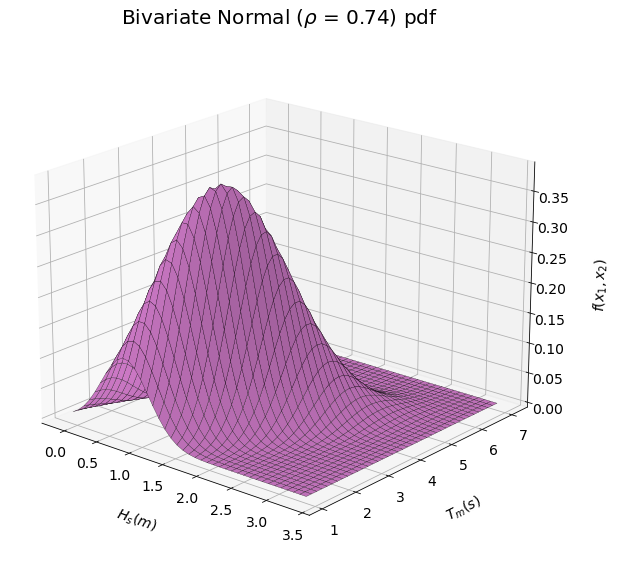

In [14]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z.reshape(X1.shape), color='#F792EF', edgecolor='black', linewidth=.25)
ax.set_xlabel('$H_s(m)$',labelpad=20)
ax.set_ylabel('$T_m(s)$',labelpad=20)
ax.set_zlabel('$f(x_1,x_2)$',labelpad=20)
ax.set_title(f'Bivariate Normal ($\\rho$ = {round(rho, 2)}) pdf', fontsize=20)
ax.view_init(ax.elev-10, ax.azim+10)
plt.show()

And what about the cdf?

$
P(X_1 \leq x_1, X_2 \leq x2) = \begin{gather*}
    \int_{-\infty}^{x_1}\int_{-\infty}^{x_2} f(s_1, s_2) \,ds_1 \,ds_2
    \end{gather*}
$

In [15]:
p = multivariate_normal(mean=mu, cov=sigma).cdf(X)

Let's see how it looks too.

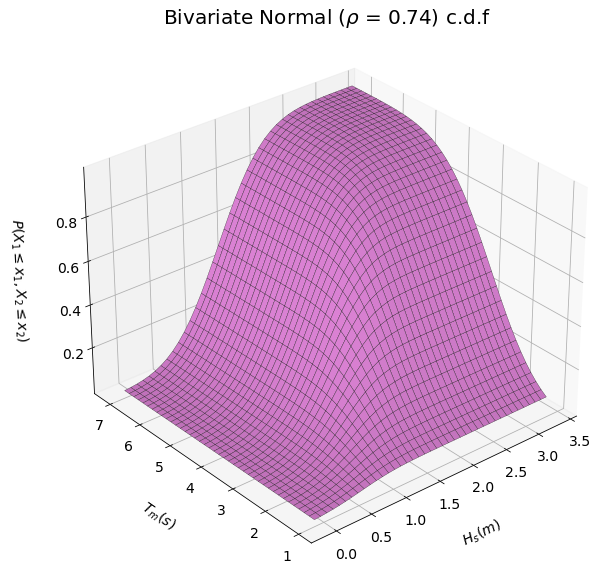

In [16]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, p.reshape(X1.shape), color='#F792EF', edgecolor='black', linewidth=.25)
ax.set_xlabel('$H_s(m)$',labelpad=20)
ax.set_ylabel('$T_m(s)$',labelpad=20)
ax.set_zlabel('$P(X_1 \leq x_1, X_2 \leq x_2)$',labelpad=20)
ax.set_title(f'Bivariate Normal ($\\rho$ = {round(rho, 2)}) c.d.f', fontsize=20)
ax.view_init(ax.elev, ax.azim-70)
plt.show()

Once we have fitted the parametric bivariate normal distribution to our data, we should assess the goodness of fit to answer the question: is it a good representation of my data?

You will learn how to do it in subsequent courses of your MSc.

You have seen how to play with the bivariate normal distribution. 
    
 <span style='background : yellow' > **Task #4: Using the above functions, compute the probability that $H_s \leq 1m$ AND $T_m \leq 4s$, denoted as $P[H_s \leq 1, T_m \leq 4]$.** </span>
 
 *Remember that we used the function multivariate_normal(mean=mu, cov=sigma).cdf(X) to evaluate the cdf*

In [22]:
p_1_4 = multivariate_normal(mean=mu, cov=sigma).cdf([1, 4])

In [18]:
print(p_1_4)

0.5143302419256635


In [23]:
p_1_4 = multivariate_normal.cdf([1, 4], mean=mu, cov=sigma)

In [24]:
print(p_1_4)

0.5143302419256635


 <span style='background : yellow' > **BONUS (go back once you are done with the rest of the assignment): Compute the probability that $H_s > 1m$ AND $T_m > 4s$, denoted as $P[H_s > 1, T_m > 4]$.** </span>

In [ ]:
from scipy.stats import norm
Hs_1 = norm.cdf(1, loc=mu[0], scale=np.sqrt(sigma[0,0]))
Tm_4 = norm.cdf(4, loc=mu[1], scale=np.sqrt(sigma[1,1]))
both = multivariate_normal.cdf([1, 4], mean=mu, cov=sigma)
p_1_4 = 1 - (Hs_1 + Tm_4 - both)
print(p_1_4)

### 3. Analyzing the conditional bivariate normal distribution function

Here you have the function which calculates the parameters of the conditional normal distribution.

<span style='background : yellow' > **Don't worry about this code, you are not required to know how to do it**</span>


In [ ]:
def ConditionalNormal(M, S, idxC, valC):
    """
    CondionalNormal calculates the parameters of the conditional 
    normal distribution
    
    Parameters
    ----------
    M : numpy.ndarray
        Mean vector of the multivariate normal
    S : numpy.ndarray
        Covariance matrix of the multivariate normal
    idxC : list
        Index/Indices of the conditioning nodes
    valC : numpy.ndarray
        Values of the conditioning nodes
        
    Returns
    -------
    Mc : numpy.ndarray
        Mean vector of the conditional multivariate normal on valC
    Sc : numpy.ndarray
        Covariance matrix of the conditional multivariate normal valC
    """
    if not isinstance(M,np.ndarray):
        M = np.array(M)
    D = len(M)  # Dimension of the multivariate normal
    idxNC = list(list(set(range(D)) - set(idxC)))
    # Calculation of the conditional normal distribution:
    M1 = M[idxNC]
    S11 = S[np.ix_(idxNC, idxNC)]
    X2 = valC
    M2 = M[idxC]
    S22 = S[np.ix_(idxC, idxC)]
    S12 = S[np.ix_(idxNC, idxC)]
    S21 = S[np.ix_(idxC, idxNC)]
    S22_inv = np.linalg.inv(S22)

    Sc = S11 - S12 @ S22_inv @ S21
    Mc = M1 + S12 @ S22_inv @ (X2 - M2)
    return Mc, Sc

In order to apply the above function, we need to define the parameters to condicionalize the distribution. We need to indicate the indeces of the conditioning variable and the value of the variable. In this case, we are conditioning the first variable ($H_s(m)$) given the value of the second variable ($T_m(s)$)

In [ ]:
idxC = [1] # list of Index/Indices of the conditioning variable
valC = 6 # Values of the conditioning variable, here 6s

Now, we can apply the previously defined function to calculate the parameters of the conditional distribution.

In [ ]:
[Mc, Sc] = ConditionalNormal(mu, sigma, idxC ,valC)

And calculate the marginal and conditional distribution for the first variable.

In [ ]:
po = norm.cdf(eval_Hs,mu[0],s1)
poc = norm.cdf(eval_Hs,Mc,Sc**0.5).reshape(po.shape)

In the following plot, we compare the marginal and conditional distribution for the first variable.

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(eval_Hs,po,'k', label = f'N({np.round(mu[0], 3)},{np.round(s1, 3)})' )
plt.plot(eval_Hs,poc,'m', label = f'Conditional N({np.round(Mc[0],3)},{np.round(Sc[0][0]**.5,3)})')
plt.ylabel(f'$P(X_1 \leq x_1)$  &  $P(X_1 \leq x_1|T_m = {valC})$')
plt.xlabel(f'$X_1 = H_s(m)$')
plt.title('cdf & conditional cdf for Gaussian random variable')
plt.grid('--', color='gray', alpha=.3)
plt.legend(loc='lower right')
plt.show()

You can see that the mean of the conditional cdf is higher than the mean of the marginal cdf. This is because we are conditionalizing it with a value of $T_m$ higher than the mean and a positive correlation exists between both variables (large values of $H_s$ occur with large values of $T_m$)

<span style='background : yellow' > **Task #5: Let's go through the calculations using pencil and paper.** You have calculated the parameters of the conditional marginal distribution for $H_s$ given a value of $T_m=6s$ using the given code. Now, it is the moment to get pencil and paper and start working on our maths. </span>

You know:
- We are working with a bivariate normal distribution
- The means of $H_s$ and $T_m$
- The standard deviations of $H_s$ and $T_m$
- The covariance and correlation coefficient of $H_s$ and $T_m$

Go to the presentation of the bivariate video and follow the calculations considering your data and check that the mean and standard deviations of the conditional distribution of $H_s$ given $T_m=6s$ are 2.14 and 0.44 (see previous figure).

*Watch that part of the video again if needed.*

### 4. Moving to three dimensions

In engineering and geosciences problems, more than two variables are typically involved. Here, you will be shown how complicated these problems can become when using multivariate distributions. Further in your MSc program, there will be courses which will teach you how to develop efficient multivariate dependence models. Ensure you enroll for them!

From now on, we are going to follow the example of the video. The dataset is not used anymore.

Let's compute the conditional density of a 3 dimensional normal distribution. First, we need to give a value to the parameters and select the conditioning variable and its value.

In [ ]:
mu3 = [-3, 5, 4]
s1 = 5  #sigma_1
s2 = 4  #sigma_2
s3 = 6
rho = -0.77 
rho13 = 0.4
rho23 = 0.2
idxC = [2] # list of Index/Indices of the conditioning variable
valC = 6 # Values of the conditioning variable

Based on this values, we define the mean and covariance matrixes, and compute the parameters of the conditional distribution.

In [ ]:
cvr = s1*s2*rho  #Covariance
cv13 = s1*s3*rho13
cv23 = s2*s3*rho23

sigma = np.array([[s1**2 , cvr], [cvr, s2**2]])
SS = np.array([[s1**2, cvr, cv13], [cvr, s2**2, cv23], [cv13, cv23, s3**2]])

[Mc, Sc] = ConditionalNormal(mu3, SS, idxC ,valC)
rhoc = Sc[0,1]/(Sc[0,0]**0.5*Sc[1,1]**0.5)

With the updated value of the parameters, we can calculate the density of the conditional distribution.

In [ ]:
x11 = np.linspace(Mc[0]-3.8*Sc[0,0]**0.5,Mc[0]+3.8*Sc[0,0]**0.5,n)
x22 = np.linspace(Mc[1]-3.8*Sc[1,1]**0.5,Mc[1]+3.8*Sc[1,1]**0.5,n)

[X1c,X2c] = np.meshgrid(x11,x22)

Xc = np.array([np.concatenate(X1c.T), np.concatenate(X2c.T)]).T
Zc = multivariate_normal(mean=Mc, cov=Sc).pdf(Xc)

And compare the conditional and non-conditional densities.

In [ ]:
x1 = np.linspace(mu[0]-3.8*s1,mu[0]+3.8*s1,n)
x2 = np.linspace(mu[1]-3.8*s1,mu[1]+3.8*s2,n)

X1,X2 = np.meshgrid(x1,x2)
X = np.array([np.concatenate(X1.T), np.concatenate(X2.T)]).T
Z = multivariate_normal(mean=mu, cov=sigma).pdf(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z.reshape(X1.shape), alpha = .8,color = '#F792EF', edgecolor='black', linewidth=.25, label='nonconditional')
ax.plot_surface(X1c, X2c, Zc.reshape(X1c.shape), color = '#00CEFF',  edgecolor='black', linewidth=.25, label='conditional')
ax.set_xlabel('$X_1$',labelpad=20)
ax.set_ylabel('$X_2$',labelpad=20)
ax.set_zlabel('$\phi(x_1,x_2)$',labelpad=20)
ax.set_title(f'pdf Nonconditional($\\rho$ = {np.round(rho, 3)}) \n' f'and Conditional 2d Normal', fontsize=20)
colors = ['#F792EF','#00CEFF']
texts = ['Nonconditional', 'Conditional']
legend_box = [plt.plot([],[], marker="o", ms=8,ls="", mec='#555555', color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts))]
ax.legend(handles=legend_box, numpoints = 1)
ax.view_init(ax.elev-10, ax.azim+10)
plt.show()

<span style='background : yellow' > **Task #6: Play around with the view (azim, elev) and with the value of the conditioned variable (valC).** </span> How does this affect to the density function?

In [ ]:
import ipywidgets as widgets

@widgets.interact(valC = (-16,16,), azim = (-100,60,5) , elev = (0,50,5) )

def update(valC=6, azim=-40, elev=10):
    [Mc, Sc] = ConditionalNormal(mu3, SS, idxC ,valC)
    rhoc = Sc[0,1]/(Sc[0,0]**0.5*Sc[1,1]**0.5)

    x11 = np.linspace(Mc[0]-3.8*Sc[0,0]**0.5,Mc[0]+3.8*Sc[0,0]**0.5,n)
    x22 = np.linspace(Mc[1]-3.8*Sc[1,1]**0.5,Mc[1]+3.8*Sc[1,1]**0.5,n)

    [X1c,X2c] = np.meshgrid(x11,x22)

    Xc = np.array([np.concatenate(X1c.T), np.concatenate(X2c.T)]).T
    Zc = multivariate_normal(mean=Mc, cov=Sc).pdf(Xc)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1, X2, Z.reshape(X1.shape), alpha = .8,color = '#F792EF', edgecolor='black', linewidth=.25, label='nonconditional')
    ax.plot_surface(X1c, X2c, Zc.reshape(X1c.shape), color = '#00CEFF',  edgecolor='black', linewidth=.25, label='conditional')
    ax.set_xlabel('$X_1$',labelpad=20)
    ax.set_ylabel('$X_2$',labelpad=20)
    ax.set_zlabel('$\phi(x_1,x_2)$',labelpad=20)
    ax.set_title(f'pdf Nonconditional($\\rho$ = {rho}) \n' f'and Conditional 2d Normal', fontsize=20)
    colors = ['#F792EF','#00CEFF']
    texts = ['Nonconditional', 'Conditional']
    legend_box = [plt.plot([],[], marker="o", ms=8,ls="", mec='#555555', color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts))]
    ax.legend(handles=legend_box, numpoints = 1)
    ax.view_init(elev=elev, azim=azim)

*Correlation has increased, so the density is more concentrated in the diagonal than it was in the nonconditional case.*